In [46]:
# Package Imports

# File management
import os

# Data/numeric manipulation
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

# Pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Modelling & Evaluation
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from mlxtend.evaluate import feature_importance_permutation
from lime.lime_tabular import LimeTabularExplainer


In [55]:
### Load Data

# Read in data
train_data = pd.read_csv(r'C:\Users\Angus\Documents\UTS MDSI\Advanced DSI\NBA Kaggle\adsi_g5_kaggle_nba\data\train.csv')
test_data = pd.read_csv(r'C:\Users\Angus\Documents\UTS MDSI\Advanced DSI\NBA Kaggle\adsi_g5_kaggle_nba\data\test.csv')

In [57]:
# Adjust data
train_data_x = train_data.copy()
train_data_x = train_data_x.drop(['Id_old', 'Id'], axis=1)
train_data_target = train_data_x.pop('TARGET_5Yrs')
test_data_x = test_data.drop(['Id_old', 'Id'], axis=1)

# Don't MinMax Adjust data
"""scaler = StandardScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(train_data_x), columns=train_data_x.columns)
df_test_data_scaled = pd.DataFrame(scaler.fit_transform(test_data_x), columns=test_data_x.columns)"""

# train test val splits
X_data, X_test, y_data, y_test = train_test_split(train_data_x, train_data_target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [58]:
# Set XGBoost model
# Source: https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

# Previous CV optimised inputs
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
xgb.fit(X_train, y_train)
print(xgb)

c:\users\angus\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:34:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [59]:
# Source: http://rasbt.github.io/mlxtend/user_guide/evaluate/feature_importance_permutation/
# Compute the feature importance directly from the model via mean impurity decrease

print('Training accuracy:', np.mean(xgb.predict(X_train) == y_train)*100)
print('Validation accuracy:', np.mean(xgb.predict(X_val) == y_val)*100)

importance_vals = xgb.feature_importances_
print(importance_vals)

Training accuracy: 83.9453125
Validation accuracy: 84.21875
[0.13001034 0.0364976  0.04275471 0.11527169 0.0402118  0.07654376
 0.03514921 0.03021906 0.03708431 0.03440359 0.04906075 0.03648213
 0.05386395 0.03509471 0.09201939 0.03688902 0.03835095 0.04040034
 0.03969264]


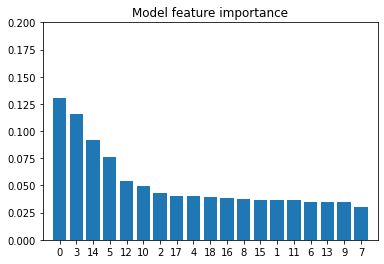

In [60]:
# Chart the mean impurity decrease

std = np.std([xgb.feature_importances_], #[tree.feature_importances_ for tree in xgb.estimators_]
             axis=0)
indices = np.argsort(importance_vals)[::-1]

# Plot the feature importances of the model
plt.figure()
plt.title("Model feature importance")
plt.bar(range(df_train_scaled.shape[1]), importance_vals[indices],
        yerr=std[indices], align="center")
plt.xticks(range(df_train_scaled.shape[1]), indices)
plt.xlim([-1, df_train_scaled.shape[1]])
plt.ylim([0, 0.2])
plt.show()

In [61]:
# Use mlxtend for feature importance analysis on the validation set compared to prior trained set

# MLXtend prefers arrays as inputs rather than pandas
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
#refit with np arrays
xgb.fit(X_train.to_numpy(), y_train.to_numpy())

c:\users\angus\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:34:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [62]:
# MLXtend

imp_vals, _ = feature_importance_permutation(
    predict_method=xgb.predict, 
    X=X_val.to_numpy(), #np array
    y=y_val.to_numpy(), #np array
    metric='accuracy',
    num_rounds=1,
    seed=1)

imp_vals

array([ 0.0015625 ,  0.        , -0.003125  ,  0.        ,  0.        ,
       -0.0015625 ,  0.0015625 , -0.00078125,  0.        ,  0.00078125,
        0.        ,  0.0015625 ,  0.        ,  0.00078125,  0.003125  ,
        0.00078125,  0.0015625 ,  0.0015625 ,  0.        ])

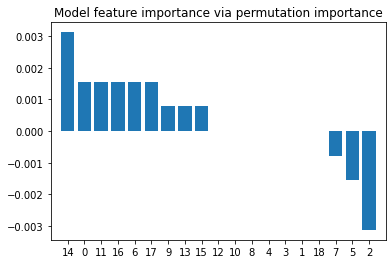

In [63]:
# Chart feature importance via permutation importance

indices = np.argsort(imp_vals)[::-1]
plt.figure()
plt.title("Model feature importance via permutation importance")
plt.bar(range(df_train_scaled.shape[1]), imp_vals[indices])
plt.xticks(range(df_train_scaled.shape[1]), indices)
plt.xlim([-1, df_train_scaled.shape[1]])
#plt.ylim([0, 0.01])
plt.show()

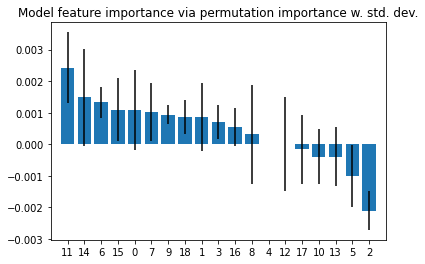

In [64]:
# Chart feature importance via permutation importance w. std. dev

imp_vals, imp_all = feature_importance_permutation(
    predict_method=xgb.predict, 
    X=X_val.to_numpy(), #np array
    y=y_val.to_numpy(), #np array
    metric='accuracy',
    num_rounds=10,
    seed=1)


std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]

plt.figure()
plt.title("Model feature importance via permutation importance w. std. dev.")
plt.bar(range(df_train_scaled.shape[1]), imp_vals[indices],
        yerr=std[indices])
plt.xticks(range(df_train_scaled.shape[1]), indices)
plt.xlim([-1, df_train_scaled.shape[1]])
plt.show()

In [65]:
### Using LIME package

explainer = LimeTabularExplainer(
    np.array(X_train),
    feature_names=train_data_x.columns,
    class_names=["<5y", ">5y"],
    mode='classification')

"""explainer = lime.lime_tabular.LimeTabularExplainer(
np.array(X_train),
feature_names=train_data_x.columns,
class_names=["<5y", ">5y"],       mode='classification')"""


exp = explainer.explain_instance(
   np.array(X_val)[0],
   xgb.predict_proba,
   top_labels=1,
   num_features=19)


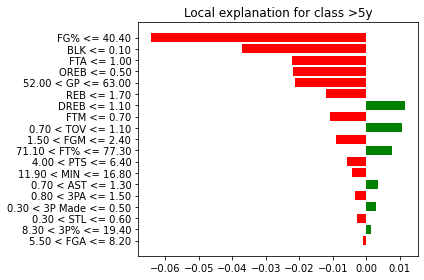

In [66]:
exp.as_pyplot_figure()

plt.tight_layout()

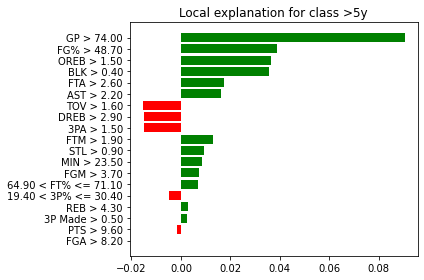

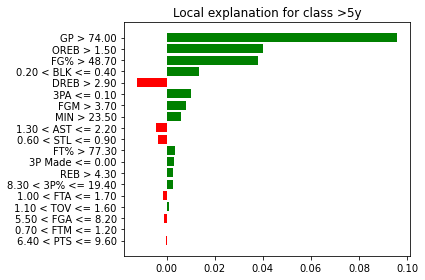

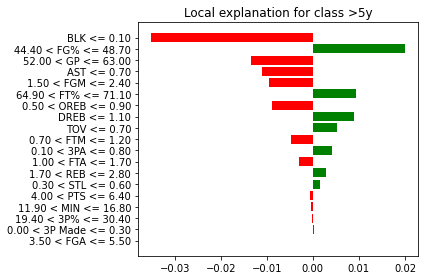

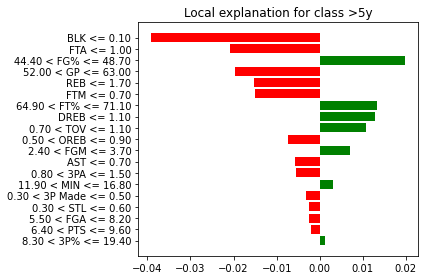

In [68]:
for i in [11, 14, 3, 6]:
    exp = explainer.explain_instance(np.array(X_val)[i], xgb.predict_proba,
            num_features=19)
    exp.as_pyplot_figure()
    plt.tight_layout()